In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import itertools
import warnings

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

# Урок 3. Кейс 1. Работа с признаками и селекция.

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.**

In [11]:
data = pd.read_csv('./datasets/my_PJME_MW.csv', index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [12]:
data_month = data.resample('M').mean()

data_month.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


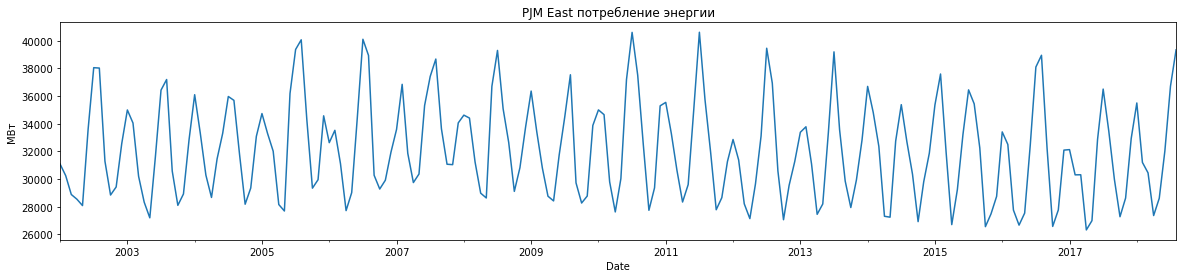

In [13]:
data_month['PJME_MW'].plot(style='-', figsize=(20,4))
plt.title('PJM East потребление энергии')
plt.ylabel('МВт')
plt.show()

**2. Подберите параметры модели SARIMAX для этого ряда.**

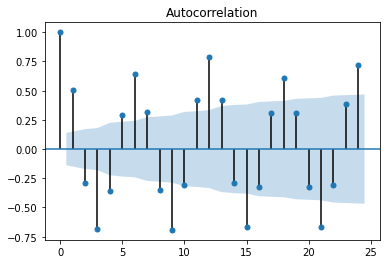

In [14]:
sm.graphics.tsa.plot_acf(data_month['PJME_MW'], lags=12*2)
plt.show()

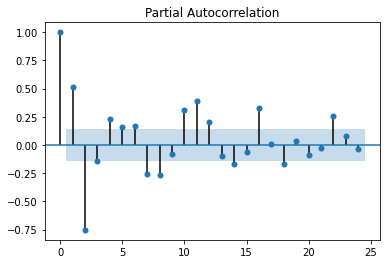

In [15]:
sm.graphics.tsa.plot_pacf(data_month['PJME_MW'], lags=12*2)
plt.show()

График ACF имеет форму синусойды и выделяющийся лаг 1; PACF имеет форму убывающей по экспоненте синусойды и резко выделяющиеся лаги 1 и 2. Значит целесообразно брать $p = 2$ и $q = 2$. Из графика ACF видим сезонную составляющую в 6 месяцев и более сильную сезонную составляющую в 12 месяцев. Границы для $p$ и $q$ определили, найдём значения $d$ по критерию Дики-Фулера.

In [16]:
# нет разности
sm.tsa.stattools.adfuller(data_month['PJME_MW'], regression='ct')

(-2.6305818240368954,
 0.26601840067282856,
 15,
 184,
 {'1%': -4.008832839770228,
  '5%': -3.434625048376243,
  '10%': -3.141221698677776},
 3230.062059143975)

In [17]:
# первая разность
sm.tsa.stattools.adfuller(data_month['PJME_MW'].diff(1)[1:], regression='ct')

(-6.055831211690891,
 1.6754622441797507e-06,
 14,
 184,
 {'1%': -4.008832839770228,
  '5%': -3.434625048376243,
  '10%': -3.141221698677776},
 3217.557676725865)

In [18]:
# вторая разность
sm.tsa.stattools.adfuller(data_month['PJME_MW'].diff(1).diff(1)[2:], regression='ct')

(-7.846327761738932,
 1.61908988905104e-10,
 15,
 182,
 {'1%': -4.009392790586421,
  '5%': -3.434893396561173,
  '10%': -3.141378799874199},
 3228.597432681513)

Видим что брать $d$ больше 2 нет смысла. Используем сеточный выбор для подбора оптимальных параметров модели SARIMA. Качество модели оцениваем по критерию Акаике (AIC), чем он меньше, тем лучше.

In [290]:
# Коэффициенты модели ARIMA p, d и q в диапазоне 0-2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Коэффициенты модели S p, d, q в этих же диапазонах
pdq_seasonal = list(itertools.product(p, d, q, [12]))

In [291]:
warnings.filterwarnings("ignore") # отключает предупреждения

coefs = []
for param in pdq:
    for param_seasonal in pdq_seasonal:
        model = sm.tsa.statespace.SARIMAX(
           data_month['PJME_MW'].values[:-30],
           order=param,
           seasonal_order=param_seasonal,
           enforce_stationarity=False,
           enforce_invertibility=False
        )

        results = model.fit()
        coefs.append((param, param_seasonal, results.aic))
        # print(f'ARIMA{param}x{param_seasonal}3 - AIC:{results.aic}')

In [294]:
coefs.sort(key=lambda tup: tup[2])
coefs[:20]

[((2, 2, 2), (0, 2, 2, 12), 2098.330295969929),
 ((1, 1, 2), (1, 2, 2, 12), 2114.854512777258),
 ((0, 2, 2), (0, 2, 2, 12), 2116.01211572623),
 ((0, 2, 2), (1, 2, 2, 12), 2116.391776891371),
 ((0, 1, 2), (0, 2, 2, 12), 2117.473336245644),
 ((0, 1, 2), (1, 2, 2, 12), 2118.7667869012803),
 ((0, 1, 2), (2, 2, 2, 12), 2120.4887322513664),
 ((2, 1, 2), (2, 2, 2, 12), 2126.7324945295763),
 ((2, 1, 2), (0, 2, 2, 12), 2126.74950767178),
 ((1, 1, 2), (2, 2, 2, 12), 2128.1517046144068),
 ((1, 1, 1), (0, 2, 2, 12), 2129.350408299649),
 ((1, 1, 2), (0, 2, 2, 12), 2129.9107721669775),
 ((1, 1, 1), (1, 2, 2, 12), 2131.119000043878),
 ((1, 1, 1), (2, 2, 2, 12), 2132.352116066683),
 ((2, 1, 1), (1, 2, 2, 12), 2132.6705202375188),
 ((0, 2, 2), (2, 2, 2, 12), 2133.698197556063),
 ((2, 1, 1), (2, 2, 2, 12), 2134.054643293398),
 ((2, 2, 2), (1, 2, 2, 12), 2137.3674365863194),
 ((2, 1, 1), (2, 2, 1, 12), 2139.604257555138),
 ((0, 1, 1), (2, 2, 2, 12), 2140.1676788841028)]

Наилучшие результаты показала модель при коэффициентах $p=2, d=2, q=2$ и коэффициентах сезонности $p=0, d=2, q=2, s=12$. Но для дальнейшего анализа выберем модель с параметрами $p=0, d=1, q=2$ и коэффициентами сезонности $p=0, d=2, q=2, s=12$ Критерий Акаике составил $AIC=2117$. Рассмотрим результаты этой модели более детально.

In [26]:
param = [0, 1, 2]
param_seasonal = [0, 2, 2, 12]
N_test = 30 # число точек тестовой выборки

model = sm.tsa.statespace.SARIMAX(
    data_month['PJME_MW'].values[:-N_test],
    order=param,
    seasonal_order=param_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

In [27]:
print(results.summary().tables[0],results.summary().tables[1])

SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  170
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 12)   Log Likelihood               -1053.737
Date:                            Mon, 10 Aug 2020   AIC                           2117.473
Time:                                    23:49:39   BIC                           2131.327
Sample:                                         0   HQIC                          2123.098
                                            - 170                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

Наиболее значимые коэффициенты модели - коэффициенты сглаживания `ma.L1` и `ma.S.L12`. Коэффициенты `P>|z|` близки к нулю и это хорошо. Рассмотрим остатки ряда `results.resid` и убедимся что они не имеют значительной корреляции.

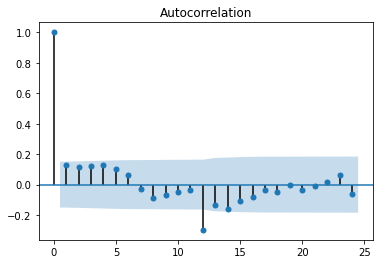

In [28]:
sm.graphics.tsa.plot_acf(results.resid, lags=24)
plt.show()

Остатки ряда имеют характер белого шума. Оценим близости распределений остатков модели к нормальному закону используя визуализацию `plot_diagnostics`.

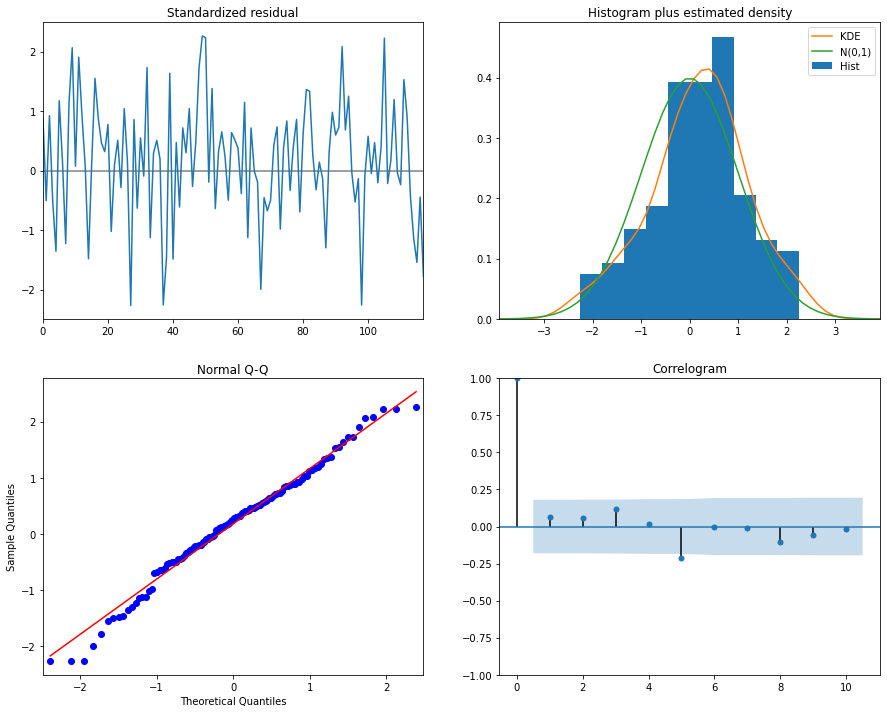

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Левый верхний график - остатки ряда. Нет проявлений сезонности, это белый шум. 

На верхнем правом графике красная линия `KDE` находится близко к линии `N(0,1)`, где `N(0,1)` является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1. Очевидно, что остатки нормально распределены. 

Левый нижний график - q-q диаграмма. Он показывает, что упорядоченное распределение остатков следует линейному тренду выборок, взятых из стандартного распределения `N(0, 1)`. Это так же признак того, что остатки нормально распределены.

Правый нижний график - график автокорреляции. Он показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель подходит для анализа и прогнозирования временного ряда. Построим прогноз по тестовой выборке и оценим предсказательные свойства модели.

In [67]:
N_pure_predict = 30 # число точек предсказания за границами выборки
N_forecast = N_test + N_pure_predict # общее число точек для предсказания
N_offset = 100 # отступ от начала данных для более удобной визуализации

In [47]:
predict_ = results.get_prediction(end=results.nobs + N_forecast)  # делаем предсказание

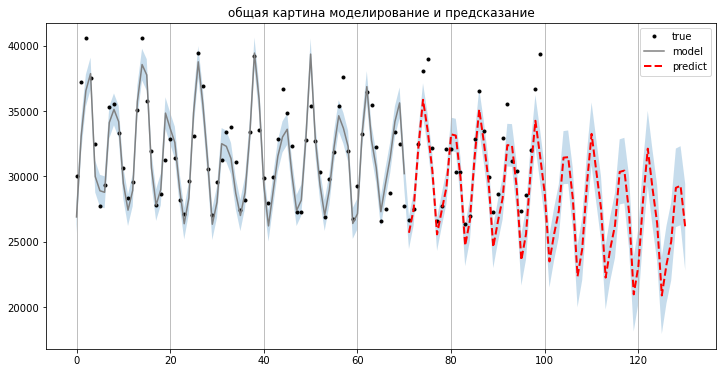

In [74]:
idx = np.arange(len(predict_.predicted_mean) - N_offset)
predict_ci = predict_.conf_int(alpha=0.5)

fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_month['PJME_MW'].values[N_offset:], 'k.',label='true')

ax.plot(idx[:-N_forecast], predict_.predicted_mean[N_offset:-N_forecast], 'gray', label = 'model')
ax.plot(idx[-N_forecast:], predict_.predicted_mean[-N_forecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N_offset:, 0], predict_ci[N_offset:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

По графикам видно что качество прогноза ухудшается с увеличением горизонта прогноза. В пределах оджного года (два пика) прогноз довольно точный, но пиковые значения не лежат в доверительном интервале 95%. 

**3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.**

Параметры модели по недельным данным: `pdq = (1,1,2)`, `pdq_seasonal = (0,1,2,52)`, `AIC = 6867.79`. Модель не изменилась по сложности. Распределение остатков у модели с месячным ресэмплингом и у модели с недельным ресэмплингом одинаково близки к нормальному распределению. Недельная модель так же плохо предсказывала пиковые значения на тренировочной выборке, однако при прогнозировании 12-и значений все они лежали в доверительном интервале 95%. То есть предсказание при недельном ресэмлинге более точные чем при месячном.

**4. Возмите вариант 1 или 2**

    Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )

Возьмём первый вариант, построим модель ARIMA для цены нефти марки brent. 

In [255]:
brent = pd.read_excel('./datasets/brent_2010_2019.xlsx', index_col=[0], parse_dates=[0])
brent_week = brent.resample('W').mean().sort_index()
brent_week.head()

,Значение
Дата,
2010-09-05,76.616000
2010-09-12,77.673333
2010-09-19,78.693333
2010-09-26,78.518333
2010-10-03,81.211667


In [256]:
brent_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Значение  469 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB


In [257]:
# Убедимся что в индексах нет дублей.
brent_week[brent_week.index.duplicated(keep=False)].size

0

In [258]:
# Убедимся что в недельном представлении нет пропущенных индексов.
pd.date_range('2010-09-05', '2019-09-01', freq="W").size == brent_week.index.size

True

In [259]:
# Проверим что в данных нет пропусков
brent_week[brent_week['Значение'].isna()]

,Значение
Дата,
2011-10-16,NaN


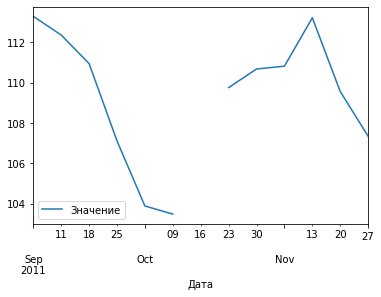

In [260]:
brent_week['2011-09-01':'2011-12-01'].plot()
plt.show()

В недельном представлении имеется 470 записей с `2010-09-05` по `2019-09-01`. Одно значение пропущено. Заполним его средним по соседним измерениям.

In [261]:
one_week = timedelta(weeks=1)
dropped_indexes = brent_week[brent_week['Значение'].isna()].index
dropped_values = []

for index in dropped_indexes:
    prev = brent_week.iloc[brent_week.index == index - one_week]['Значение'].values[0]
    next = brent_week.iloc[brent_week.index == index + one_week]['Значение'].values[0]
    curr = (prev + next) / 2
    dropped_values.append(curr)

In [262]:
df = pd.DataFrame(dropped_values, index=dropped_indexes, columns=["Значение"])
df

,Значение
Дата,
2011-10-16,106.616667


In [263]:
brent_week = brent_week.dropna().append(df, sort=False).sort_index()

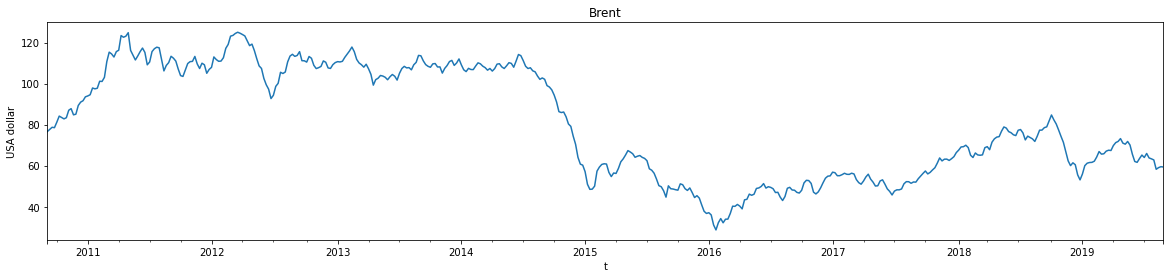

In [264]:
brent_week['Значение'].plot(style='-', figsize=(20,4))
plt.title('Brent')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.show()

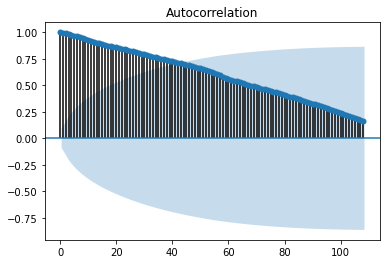

In [265]:
sm.graphics.tsa.plot_acf(brent_week['Значение'], lags=54*2)
plt.show()

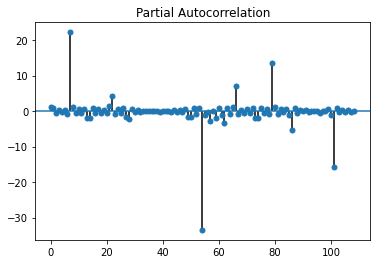

In [266]:
sm.graphics.tsa.plot_pacf(brent_week['Значение'], lags=54*2)
plt.show()

График ACF не имеет явно выраженного лага. Значения при всех лагах сильно зависимы от предыдущих; PACF имеет несколько выделяющихся лагов, но общий характер графика установить невозможно. Значения $p$ и $q$ будем варьировать от 0 до 2. Из графика ACF видим что сезонная составляющая полностью отсутствует. Найдём значения $d$ по критерию Дики-Фулера.

In [267]:
# нет разности
sm.tsa.stattools.adfuller(brent_week['Значение'], regression='ct')

(-2.300870505868834,
 0.4334684467084633,
 5,
 464,
 {'1%': -3.978414375776397,
  '5%': -3.419994493296638,
  '10%': -3.1326408685380063},
 1961.4565582681169)

In [268]:
# первая разность
sm.tsa.stattools.adfuller(brent_week['Значение'].diff(1)[1:], regression='ct')

(-7.86546788511323,
 1.4622811998527298e-10,
 4,
 464,
 {'1%': -3.978414375776397,
  '5%': -3.419994493296638,
  '10%': -3.1326408685380063},
 1958.9911453986865)

In [269]:
# вторая разность
sm.tsa.stattools.adfuller(brent_week['Значение'].diff(1).diff(1)[2:], regression='ct')

(-8.968132109925216,
 4.284611870238196e-13,
 16,
 451,
 {'1%': -3.9789846182231026,
  '5%': -3.420269730716854,
  '10%': -3.1328025785176075},
 1988.8364147898048)

Значение $d$ будем варьировать от 0 до 2.

In [270]:
# Коэффициенты модели ARIMA p, d и q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [271]:
warnings.filterwarnings("ignore")

# значения ряда для предсказания
N = 30

coefs = []
for param in pdq:
    try:
        model = ARIMA(
            brent_week['Значение'].values[:-N],
            order=param,
        )

        results = model.fit()
        coefs.append((param, results.aic))
    except:
        continue

In [272]:
coefs.sort(key=lambda tup: tup[1])
coefs[:5]

[((0, 1, 1), 1912.6362179652288),
 ((1, 1, 1), 1914.3840445065503),
 ((0, 1, 2), 1914.4206900437102),
 ((1, 1, 2), 1915.012886924619),
 ((2, 1, 0), 1915.2093589717101)]

Наилучшие показатели у модели с $p=0$, $d=1$, $q=1$. Это довольно простая модель, поэтому возьмём её для анализа.

In [273]:
param = [0, 1, 1]
model = ARIMA(
    brent_week['Значение'].values[:-N],
    order=param,
)

results = model.fit()

**5. Оцените результат моделирования.**

In [275]:
print(results.summary().tables[0],results.summary().tables[1])

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  439
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -953.318
Method:                       css-mle   S.D. of innovations              2.122
Date:                Mon, 10 Aug 2020   AIC                           1912.636
Time:                        03:06:51   BIC                           1924.890
Sample:                             1   HQIC                          1917.471
                                                                              
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0337      0.138     -0.243      0.808      -0.305       0.238
ma

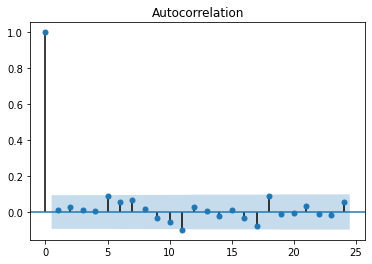

In [276]:
sm.graphics.tsa.plot_acf(results.resid, lags=24)
plt.show()

Остатки ряда имеют характер белого шума. Построим прогноз для последних 30 значений ряда.

In [277]:
sm.tsa.stattools.adfuller(results.resid)

(-20.705626748543587,
 0.0,
 0,
 438,
 {'1%': -3.445368352170937,
  '5%': -2.8681614049724002,
  '10%': -2.570296970872167},
 1832.3694564205052)

ADF ест так же показывает что остатки ряда являются стационарным рядом. Сделаем прогноз на 30 значений и сравним результат с фактическими данными.

In [278]:
y_p = results.predict(len(brent_week[:-N]), len(brent_week[:-N]), typ='levels')
y_f = results.forecast(N)

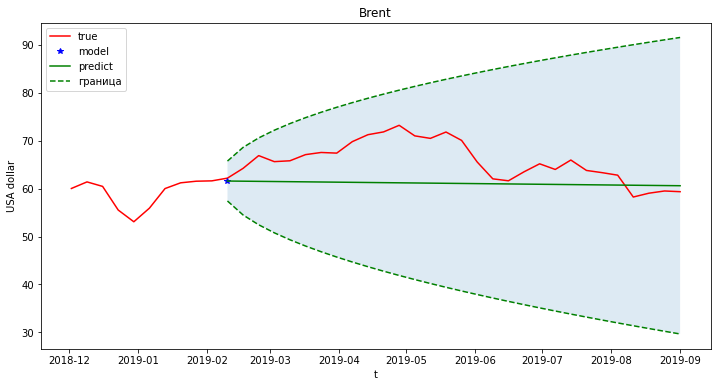

In [279]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(brent_week[-10-N:], 'r', label ='true')
plt.plot(brent_week.index[-N], y_p, '*b', label ='model')

plt.plot(brent_week.index[-N:], y_f[0], 'g', label ='predict')
plt.plot(brent_week.index[-N:], y_f[2][:,1], '--g', label = 'граница')
plt.plot(brent_week.index[-N:], y_f[2][:,0], '--g')

ax.fill_between(brent_week.index[-N:],  y_f[2][:,1], y_f[2][:,0], alpha=0.15)

plt.title('Brent')
plt.ylabel('USA dollar')
plt.xlabel('t')

plt.legend()
plt.show()

Фактические значения лежат в доверительном интервале спрогнозированных значений. То есть модель хорошо предсказывает данные. С другой стороны размах этого доверительного интервала очень большой, так что ценность данной модели низкая.

**6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.**

Не понял что нужно сделать.